## Test Kinematic Inconsistency

In [3]:
import pandas as pd
import numpy as np
import glob
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq
import tensorflow as tf
from tensorflow.keras import mixed_precision
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_global_policy(policy)
        print("GPU e Mixed Precision Attivate.")
    except RuntimeError as e:
        print(e)

#PATH
INPUT_DIR = '../Pre-Elaborazione Dati/Dataset' 
SCALER_PATH = 'scaler.joblib' 
MODEL_PATH = 'lstm_autoencoder_best.keras' 

COLONNE_FEATURES = ['Latitude', 'Longitude', 'SOG', 'COG']
WINDOW_SIZE = 30  
BATCH_SIZE = 64 

#File di Test
all_files = sorted(glob.glob(os.path.join(INPUT_DIR, '*.parquet')))
TEST_FILES = all_files[20:24]
print(f"File di Test caricati")

GPU e Mixed Precision Attivate.
File di Test caricati


In [4]:
def create_windows(data_np, window_size):
    windows = []
    for i in range(len(data_np) - window_size + 1):
        windows.append(data_np[i : i + window_size])
    return windows

def data_generator_v(file_paths, scaler, features, window_size, batch_size, shuffle_files=False):
    
    file_buffer = {} 
    window_buffer = [] 
    CHUNK_SIZE_ROWS = 500_000

    while True:
        if shuffle_files:
             # Shuffle disattivato forzatamente per garantire la sequenzialità
            shuffle_files = False 
            
        for file_path in file_paths:
            chunk_buffer = {}
            try:
                pf = pq.ParquetFile(file_path)
                for batch in pf.iter_batches(batch_size=CHUNK_SIZE_ROWS, columns=features + ['TrajectoryID']):
                    df_chunk = batch.to_pandas()
                    df_chunk[features] = scaler.transform(df_chunk[features])
                    next_chunk_buffer = {}
                    
                    for tid, group in df_chunk.groupby('TrajectoryID'):
                        if tid in chunk_buffer:
                            trajectory_data = pd.concat([chunk_buffer.pop(tid), group])
                        else:
                            trajectory_data = group
                        
                        if tid in file_buffer:
                            trajectory_data = pd.concat([file_buffer.pop(tid), trajectory_data])
                        
                        # Se la traiettoria tocca la fine del chunk, bufferizzala
                        if trajectory_data.iloc[-1].name == df_chunk.iloc[-1].name:
                            next_chunk_buffer[tid] = trajectory_data
                            continue 
                            
                        if len(trajectory_data) < window_size:
                            continue 
                            
                        trajectory_np = trajectory_data[features].to_numpy()
                        new_windows = create_windows(trajectory_np, window_size)
                        window_buffer.extend(new_windows)
                        
                        next_chunk_buffer[tid] = trajectory_data.iloc[-(window_size - 1):]

                        while len(window_buffer) >= batch_size:
                            batch_to_yield = window_buffer[:batch_size]
                            window_buffer = window_buffer[batch_size:]
                            yield (np.array(batch_to_yield), np.array(batch_to_yield))
                    
                    chunk_buffer = next_chunk_buffer
                file_buffer = chunk_buffer
            except Exception as e:
                print(f"\nErrore lettura {file_path}: {e}")
                continue
print("Funzioni definite")

Funzioni definite


In [7]:
# Carica Scaler e Modello
scaler = joblib.load(SCALER_PATH)
model = tf.keras.models.load_model(MODEL_PATH)
print("Modello e Scaler caricati.")

# Inizializza il generatore pulito
test_gen = data_generator_v(TEST_FILES, scaler, COLONNE_FEATURES, WINDOW_SIZE, BATCH_SIZE, shuffle_files=False)

Modello e Scaler caricati.


#### Funzione di Attacco

In [9]:
def apply_kinematic_attack(batch_clean, attack_start_idx=15, shift_magnitude=2.0):

    #batch_clean: Batch di dati normalizzati
    #attack_start_idx: A quale step inizia l'attacco (15 è metà finestra)
    #shift_magnitude: Di quanto spostare (in deviazioni standard)
    
    batch_attacked = batch_clean.copy()
    
    # Aggiungiamo un offset costante (simuliamo un salto istantaneo)
    # Questo crea un "gradino" impossibile nella posizione
    batch_attacked[:, attack_start_idx:, 0] += shift_magnitude # Sposta Lat
    batch_attacked[:, attack_start_idx:, 1] += shift_magnitude # Sposta Lon
    
    # non modifichiamo SOG e COG (indici 2 e 3). 
    # È qui l'incoerenza perchè la posizione cambia, ma la velocità non lo giustifica.
    
    return batch_attacked
print("Funzione di attacco definita.")

Funzione di attacco definita.


#### Creazione del dataset misto
E' stato scelto di attaccare metà dataset.

In [ ]:
# Creiamo il dataset misto
X_test_mixed = []
y_true = [] # 0 = Normale, 1 = Attacco

# Prendiamo NUM_BATCHES batch dal generatore
NUM_BATCHES = 10000

for _ in range(NUM_BATCHES):
    #Prendi dati puliti
    clean_batch, _ = next(test_gen)
    
    #Crea la versione attaccata
    attacked_batch = apply_kinematic_attack(clean_batch, shift_magnitude=3.0) # Attacco forte
    
    #Aggiungi alla lista
    #Aggiungiamo metà puliti
    half = len(clean_batch) // 2
    X_test_mixed.append(clean_batch[:half])
    y_true.extend([0] * half) # Etichetta 0
    
    #Aggiungiamo metà attaccati
    X_test_mixed.append(attacked_batch[half:])
    y_true.extend([1] * (len(clean_batch) - half)) #Etichetta 1

# Concateniamo tutto in un unico array numpy
X_test_mixed = np.concatenate(X_test_mixed)
y_true = np.array(y_true)

print(f"Dataset creato: {X_test_mixed.shape}")
print(f"Campioni Normali: {np.sum(y_true == 0)}")
print(f"Campioni Attaccati: {np.sum(y_true == 1)}")

Dataset creato: (640000, 30, 4)
Campioni Normali: 320000
Campioni Attaccati: 320000


#### Predizioni

In [26]:
print("Esecuzione predizioni sul dataset misto")
# Chiediamo al modello di ricostruire
reconstructions = model.predict(X_test_mixed, verbose=1)

# Calcoliamo l'errore MAE per ogni singolo campione
mae_per_sample = np.mean(np.abs(X_test_mixed - reconstructions), axis=(1, 2))

print("Calcolo errori completato.")

Esecuzione predizioni sul dataset misto
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step
Calcolo errori completato.


#### Istogramma comparativo

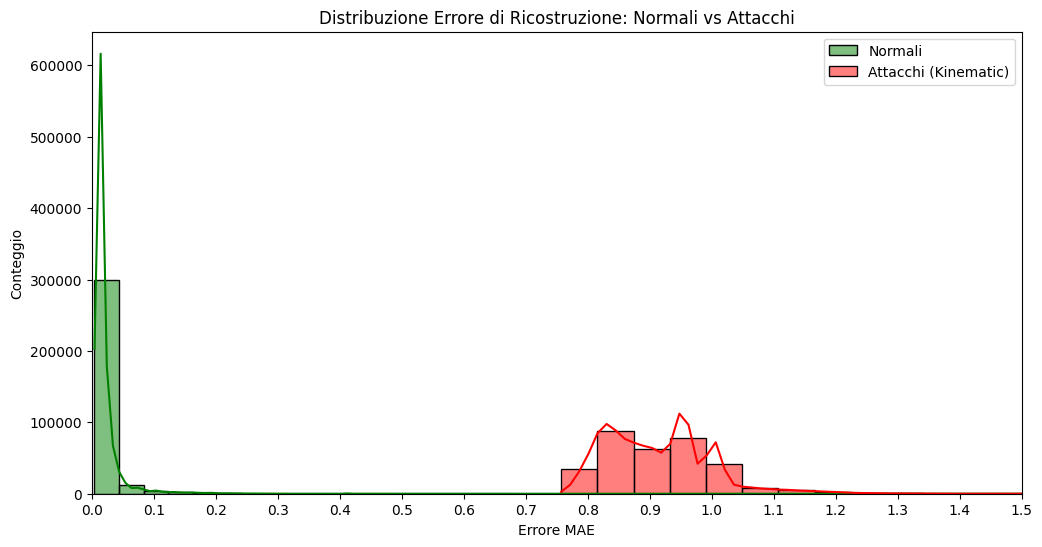

In [37]:
plt.figure(figsize=(12, 6))

# Istogramma Normali (Verde)
sns.histplot(mae_per_sample[y_true == 0], color='green', label='Normali', kde=True, bins=50, alpha=0.5)

# Istogramma Attacchi (Rosso)
sns.histplot(mae_per_sample[y_true == 1], color='red', label='Attacchi (Kinematic)', kde=True, bins=50, alpha=0.5)

plt.xlim(0, 1.5)
plt.xticks(np.arange(0, 1.6, 0.1))
#plt.xticks(np.arange(0, 1.6, 0.05), rotation=45)

plt.title("Distribuzione Errore di Ricostruzione: Normali vs Attacchi")
plt.xlabel("Errore MAE")
plt.ylabel("Conteggio")
plt.legend()
plt.show()

#### Classificazione e metriche

Soglia rilevamento calcolata (Mean + 3*Std): 0.1213

--- RISULTATI CLASSIFICAZIONE ---
Accuracy:  0.9926
Precision: 0.9853
Recall:    1.0000
F1-Score:  0.9926


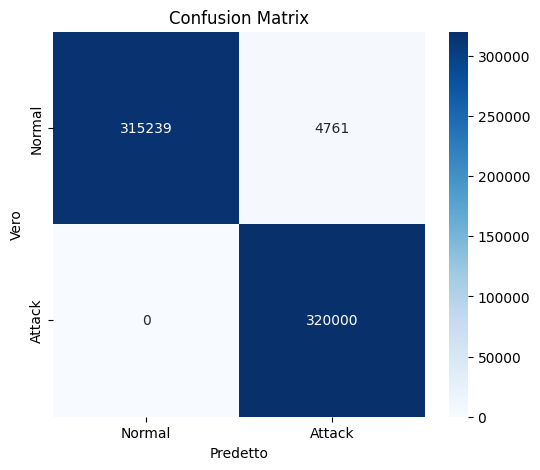

In [38]:
# Definiamo la soglia (Threshold)
errori_normali = mae_per_sample[y_true == 0]
THRESHOLD = np.mean(errori_normali) + 3 * np.std(errori_normali)
print(f"Soglia rilevamento calcolata (Mean + 3*Std): {THRESHOLD:.4f}")

# Classificazione --> Se errore > soglia -> È un attacco (1)
y_pred = (mae_per_sample > THRESHOLD).astype(int)

# Metriche
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\n--- RISULTATI CLASSIFICAZIONE ---")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Matrice di Confusione
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title("Confusion Matrix")
plt.ylabel("Vero")
plt.xlabel("Predetto")
plt.show()

#### Visualizzazione attacco

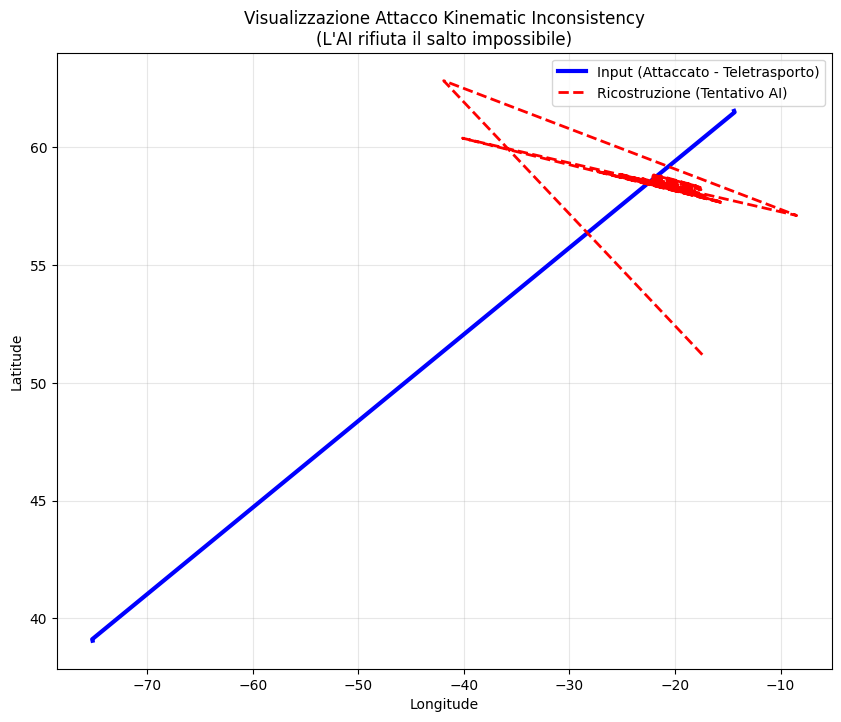

In [29]:
# Troviamo un esempio di attacco rilevato
attack_indices = np.where(y_true == 1)[0]
idx = attack_indices[0] # Il primo attacco

real_input = X_test_mixed[idx] # Questo è quello corrotto
reconstructed = reconstructions[idx] # Questo è quello che la rete ha provato a fare

# Denormalizziamo per il plot 2D
real_phys = scaler.inverse_transform(real_input)
recon_phys = scaler.inverse_transform(reconstructed)

plt.figure(figsize=(10, 8))
plt.plot(real_phys[:, 1], real_phys[:, 0], 'b-', label='Input (Attaccato - Teletrasporto)', linewidth=3)
plt.plot(recon_phys[:, 1], recon_phys[:, 0], 'r--', label='Ricostruzione (Tentativo AI)', linewidth=2)
plt.title("Visualizzazione Attacco Kinematic Inconsistency\n(L'AI rifiuta il salto impossibile)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()